In [2]:
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import math

In [3]:
def load_velo_scan(velo_filename):
    scan = np.fromfile(velo_filename, dtype=np.float32)
    scan = scan.reshape((-1, 4))
    return scan

In [4]:
#-----------------------------------相机02内参矩阵-----------------------------------
P_rect_02 = np.array( [ 7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02, 4.538225000000e+01, 
                        0.000000000000e+00,7.188560000000e+02, 1.852157000000e+02, -1.130887000000e-01,
                        0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 3.779761000000e-03]).reshape((3,4))
 
R_rect_00 = np.array( [ 9.999454e-01, 7.259129e-03, -7.519551e-03,
                        -7.292213e-03, 9.999638e-01, -4.381729e-03, 
                        7.487471e-03, 4.436324e-03, 9.999621e-01]).reshape((3,3))
 
# R_rect_02 = np.array( [ 9.999191e-01, 1.228161e-02 -3,.316013e-03,
#                         -1.228209e-02, 9.999246e-01, -1.245511e-04, 
#                         3.314233e-03, 1.652686e-04, 9.999945e-01]).reshape((3,3))
 

#velo激光雷达 到 相机00(此处已知条件重点注意) 的变换矩阵
Tr_velo_to_cam = np.array( [    7.967514e-03, -9.999679e-01, -8.462264e-04, -1.377769e-02,
                                -2.771053e-03, 8.241710e-04, -9.999958e-01, -5.542117e-02,
                                9.999644e-01, 7.969825e-03, -2.764397e-03, -2.918589e-01]).reshape((3,4))    


In [5]:
#-----------------------------------数据文件位置---------------------------------------
velo_files = r"000293.bin"
rgbimg = r"0000000293.png"
resultImg = "result_merge.png"
 
data = {}
data['P_rect_20'] = P_rect_02
# Compute the velodyne to rectified camera coordinate transforms
data['T_cam0_velo'] = Tr_velo_to_cam
data['T_cam0_velo'] = np.vstack([data['T_cam0_velo'], [0, 0, 0, 1]])
 
# pattern1:
R_rect_00 = np.insert(R_rect_00,3,values=[0,0,0],axis=0)
R_rect_00 = np.insert(R_rect_00,3,values=[0,0,0,1],axis=1)
data['T_cam2_velo'] = R_rect_00.dot(data['T_cam0_velo']) #雷达 到 相机02的变换矩阵
print(data['T_cam2_velo'])
 
pointCloud = load_velo_scan(velo_files)   #读取lidar原始数据
points = pointCloud[:, 0:3]                                           # 获取 lidar xyz (front, left, up)
points_homo = np.insert(points,3,1,axis=1).T    # 齐次化,并转置(一列表示一个点(x,y,z,1), 多少列就有多少个点)
points_homo = np.delete(points_homo,np.where(points_homo[0,:]<0),axis=1) #以列为基准, 删除深度x=0的点
 
proj_lidar = data['P_rect_20'].dot( data['T_cam2_velo'] ).dot(points_homo)  #相机坐标系3D点=相机02内参*激光雷达到相机02的变换矩阵*激光雷达3D点
cam = np.delete(proj_lidar,np.where(proj_lidar[2,:]<0),axis=1)  #以列为基准, 删除投影图像点中深度z<0(在投影图像后方)的点 #3xN
cam[:2,:] /= cam[2,:]   # 等价写法 cam[:2] /= cam[2] # 前两行元素分布除以第三行元素(归一化到相机坐标系z=1平面)(x=x/z, y =y/z)

[[ 4.27680239e-04 -9.99967248e-01 -8.08449168e-03 -1.19845993e-02]
 [-7.21062651e-03  8.08119847e-03 -9.99941316e-01 -5.40398473e-02]
 [ 9.99973865e-01  4.85948581e-04 -7.20693369e-03 -2.92196865e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


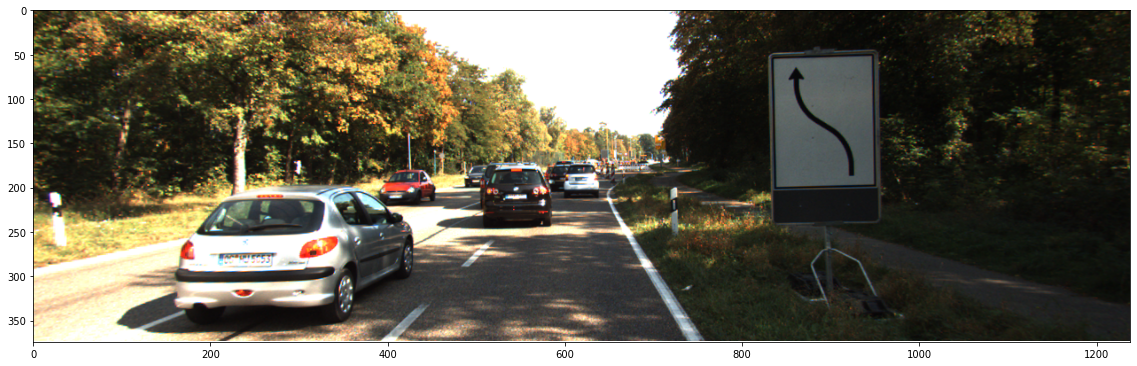

In [6]:
png = mpimg.imread(rgbimg)
IMG_H,IMG_W,_ = png.shape
plt.figure(figsize=((IMG_W)/72.0,(IMG_H)/72.0),dpi=72.0, tight_layout=True)
plt.axis([0,IMG_W,IMG_H,0])
plt.imshow(png)
plt.show() 

In [8]:
import mayavi.mlab
import open3d as o3d

pointcloud = pointCloud
print('点云数据shape:')
print(pointcloud.shape)
x = pointcloud[:, 0]  # x position of point
y = pointcloud[:, 1]  # y position of point
z = pointcloud[:, 2]  # z position of point
r = pointcloud[:, 3]  # reflectance value of point
xmin = np.amin(x, axis=0)
xmax = np.amax(x, axis=0 )
ymin = np.amin(y, axis=0)
ymax = np.amax(y, axis=0)
zmin = np.amin(z, axis=0)
zmax = np.amax(z, axis=0)
rmin = np.amin(r, axis=0)
rmax = np.amax(r, axis=0)
print("x轴最小值：{0:} x轴最大值：{1:} y轴最小值：{2:} y轴最大值：{3:} z轴最小值：{4:} z轴最大值：{5:} r最小值：{6:} r最大值：{7:}".format(xmin,xmax,ymin,ymax,zmin,zmax,rmin,rmax))
d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor
 
degr = np.degrees(np.arctan(z / d))
 
vals = 'Distance'
if vals == "height":
    col = z
else:
    col = d
 
fig = mayavi.mlab.figure(bgcolor=(0, 0, 0), size=(640, 500))
mayavi.mlab.points3d(x, y, z,
                     col,  # Values used for Color
                     mode="point",
                     colormap='spectral',  # 'bone', 'copper', 'gnuplot'
                     # color=(0, 1, 0),   # Used a fixed (r,g,b) instead
                     figure=fig,
                     )
 
# 绘制原点
mayavi.mlab.points3d(0, 0, 0, color=(1, 1, 1), mode="sphere",scale_factor=0.2)
# 绘制坐标
axes = np.array(
    [[20.0, 0.0, 0.0, 0.0], [0.0, 20.0, 0.0, 0.0], [0.0, 0.0, 20.0, 0.0]],
    dtype=np.float64,
)
#x轴
mayavi.mlab.plot3d(
    [0, axes[0, 0]],
    [0, axes[0, 1]],
    [0, axes[0, 2]],
    color=(1, 0, 0),
    tube_radius=None,
    figure=fig,
)
#y轴
mayavi.mlab.plot3d(
    [0, axes[1, 0]],
    [0, axes[1, 1]],
    [0, axes[1, 2]],
    color=(0, 1, 0),
    tube_radius=None,
    figure=fig,
)
#z轴
mayavi.mlab.plot3d(
    [0, axes[2, 0]],
    [0, axes[2, 1]],
    [0, axes[2, 2]],
    color=(0, 0, 1),
    tube_radius=None,
    figure=fig,
)
mayavi.mlab.show()

点云数据shape:
(114946, 4)
x轴最小值：-79.1449966430664 x轴最大值：78.65399932861328 y轴最小值：-61.16899871826172 y轴最大值：63.319000244140625 z轴最小值：-8.567999839782715 z轴最大值：2.9089999198913574 r最小值：0.0 r最大值：0.9900000095367432


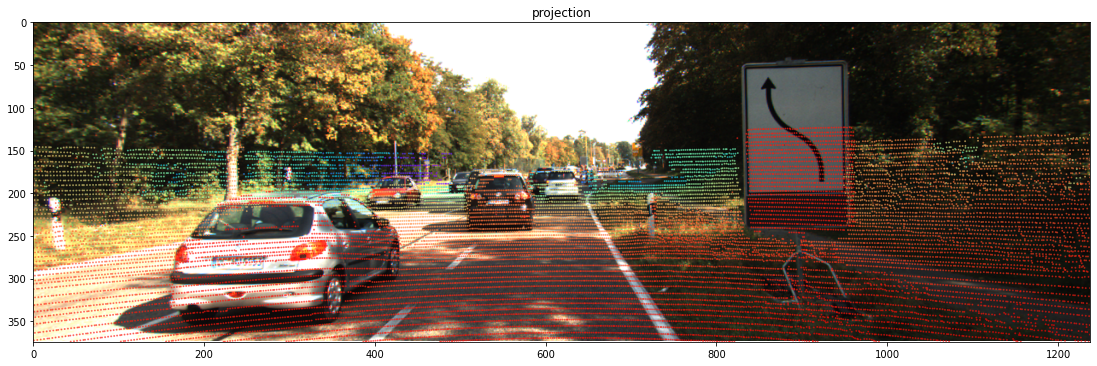

In [17]:
# -----------------------------------将激光投影点绘制到图像平面:绘制原图------------------------------------
png = mpimg.imread(rgbimg)
IMG_H,IMG_W,_ = png.shape
plt.figure(figsize=((IMG_W)/72.0,(IMG_H)/72.0),dpi=72.0, tight_layout=True)
# restrict canvas in range
plt.axis([0,IMG_W,IMG_H,0])
# plt.axis('off') 
plt.imshow(png) #在画布上画出原图
 
# filter point out of canvas
u,v,z = cam
u_out = np.logical_or(u<0, u>IMG_W)
v_out = np.logical_or(v<0, v>IMG_H)
outlier = np.logical_or(u_out, v_out)
cam = np.delete(cam,np.where(outlier),axis=1)
# generate color map from depth
u,v,z = cam
 
# 将激光投影点绘制到图像平面:绘制激光深度散点图
plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=1)
plt.title("projection")
plt.savefig(resultImg,bbox_inches='tight')
plt.show()  #在画布上画出散点雷达深度投影

In [ ]:
#-----------------------------------单独保存深度图像成灰度图像---------------------------------------------------
image_array = np.zeros((IMG_H, IMG_W), dtype=np.int16)
for i in range(cam.shape[1]):
    x = int(round(u[i]))
    y = int(round(v[i]))
 
    # x = math.ceil(u[i]) #向上取整
    # y = math.ceil(v[i])
 
    depth =  int(z[i]*256)
    if 0<x<image_array.shape[1] and 0<y<image_array.shape[0]:
        image_array[y,x] = depth
 
image_pil = Image.fromarray(image_array, 'I;16')   
image_pil.save("result_16.png")
 
 
 
print("done")